<a href="https://colab.research.google.com/github/6058ah/BusinessCapstone/blob/master/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84_%ED%86%B5%ED%95%9C_%EB%B3%80%EC%88%98_%EB%B3%84_ETF_%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1_%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 통한 변수 별 ETF 주가 예측 비교

#간단 EDA

In [1]:
#한글 폰트 다운로드
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import matplotlib.font_manager as fm
fm._rebuild()
## 런타임 다시 시작 필수

In [1]:
!pip install pykrx

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 256kB 9.8MB/s 


In [2]:
from pykrx import stock
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd #데이터프레임

#종목 코드 확인
tickers = stock.get_etf_ticker_list('20210430')
tickers = pd.DataFrame(tickers,columns = ['종목코드'])

url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])
df=df[['itemcode','itemname']]
df=df.rename(columns={'itemcode':'종목코드','itemname':'종목명'})

etf = pd.merge(left = tickers, right = df, how = 'left', on= '종목코드')
battery_etf = etf[etf['종목명'].str.contains('2차전지')]
battery_etf = battery_etf.drop(index=122) #뉴딜테마는 최근 테마이기에 데이터양이 부족해 제외
battery_etf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


,종목코드,종목명
116,305540,TIGER 2차전지테마
240,305720,KODEX 2차전지산업


  #### .iloc: 숫자 기반 인덱싱 i.e. .iloc[:,3]

  #### .loc: 문자 기반 인덱싱 i.e. .loc[:,'a']

  #### .ix: 숫자와 문자 둘 다 사용 가능 

In [3]:
#일일 종가 데이터
stocks = dict()
for a, b in battery_etf[['종목명','종목코드']].itertuples(index=False):
  price = stock.get_etf_ohlcv_by_date("20180912","20210430",b)
  stocks[a]=price['종가'].values[:].tolist()
prices = pd.DataFrame(stocks)
prices.index = price.index
prices

,TIGER 2차전지테마,KODEX 2차전지산업
날짜,,
2018-09-12,9805,9810
2018-09-13,9805,9775
2018-09-14,9915,9935
2018-09-17,10015,9990
2018-09-18,10220,10170
...,...,...
2021-04-26,18705,19720
2021-04-27,18600,19795
2021-04-28,18250,19500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'up per left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


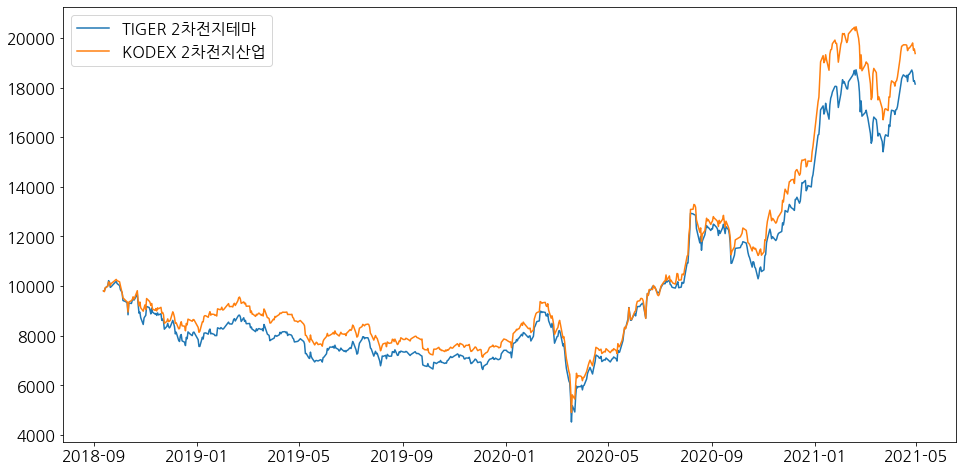

In [4]:
stocks = dict()
for a, b in battery_etf[['종목명','종목코드']].itertuples(index=False):
  price = stock.get_etf_ohlcv_by_date("20180912","20210430",b)
  stocks[a]=price['종가'].values[:].tolist()
prices = pd.DataFrame(stocks)
prices.index = price.index

import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic', size =16) 
plt.figure(figsize=(16,8))

plt.plot(prices)
plt.legend(['TIGER 2차전지테마','KODEX 2차전지산업'], loc = 'up per left')

plt.show()

##괴리율

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'up per left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


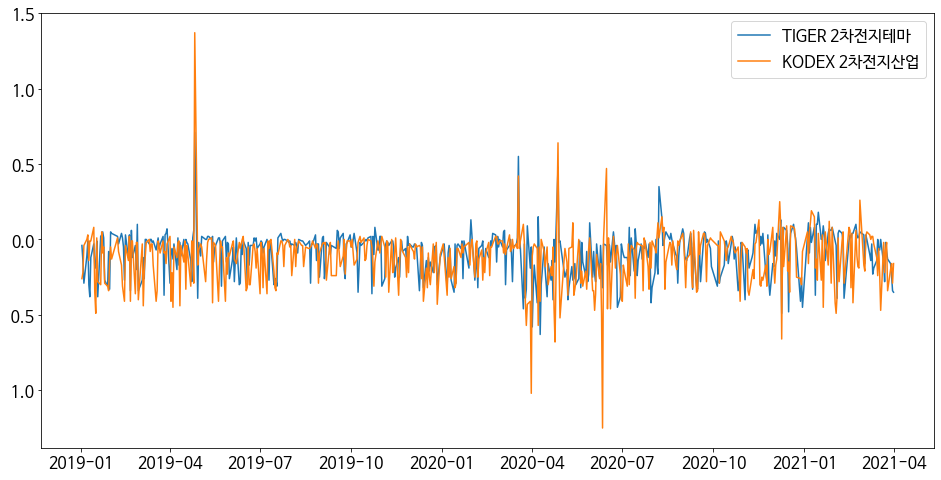

In [5]:
deviation = dict()
for a, b in battery_etf[['종목명','종목코드']].itertuples(index=False):
  dev = stock.get_etf_price_deviation("20190101","202104016",b)
  deviation[a]=dev['괴리율'].values[:].tolist()
deviations = pd.DataFrame(deviation)
deviations.index = dev.index

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic', size =16) 
plt.figure(figsize=(16,8))

plt.plot(deviations)
plt.legend(['TIGER 2차전지테마','KODEX 2차전지산업'], loc = 'up per left')

plt

##2차전지 테마 구성종목 수

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

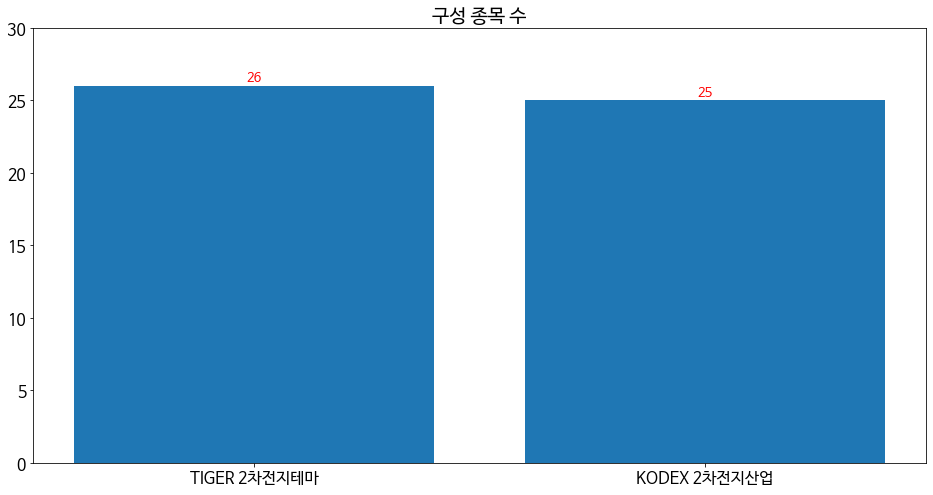

In [6]:
tiger = stock.get_etf_portfolio_deposit_file('305540','20210416')
kodex = stock.get_etf_portfolio_deposit_file('305720','20210416')

len_tiger = len(tiger)
len_kodex = len(kodex)

port = pd.DataFrame([len_tiger, len_kodex], index = ['TIGER 2차전지테마','KODEX 2차전지산업'])
port.columns = ['구성 종목 수']

plt.rc('font', family='NanumBarunGothic', size =16) 
plt.figure(figsize=(16,8))

plt.bar(port.index, port['구성 종목 수'])

for x,y in enumerate(list(port['구성 종목 수'])):
  plt.text(x,y,y, fontsize = 13, color = '#ff0000', horizontalalignment='center', verticalalignment = 'bottom')

plt.ylim(0,30)
plt.title('구성 종목 수')
plt

##총 보유자산 비교

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

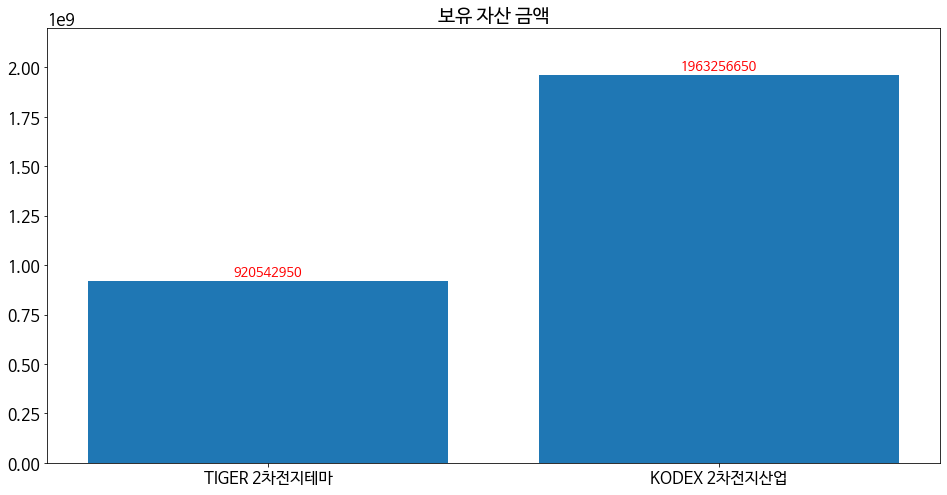

In [7]:
ti_asset = tiger['금액'].sum()
kd_asset = kodex['금액'].sum()

assets = pd.DataFrame([ti_asset, kd_asset], index = ['TIGER 2차전지테마','KODEX 2차전지산업'])
assets.columns = ['보유 자산 금액']

plt.rc('font', family='NanumBarunGothic', size =16) 
plt.figure(figsize=(16,8))

plt.bar(assets.index, assets['보유 자산 금액'])

for x,y in enumerate(list(assets['보유 자산 금액'])):
  plt.text(x,y,y, fontsize = 13, color = '#ff0001', horizontalalignment='center', verticalalignment = 'bottom')

plt.ylim(0, 2200000000)
plt.title('보유 자산 금액')
plt

##구성종목 비중 TOP 10

In [8]:
df1=pd.merge(left=tiger['비중'],right=kodex['비중'], how = 'outer', left_on=tiger.index, right_on=kodex.index)
df1= df1.set_index('key_0')
df1.columns = ['TIGER 2차전지테마','KODEX 2차전지산업']
df1=df1.fillna(0)
df2=df1[:10]
df2.index = [stock.get_market_ticker_name(x) for x in df2.index]
df2

,TIGER 2차전지테마,KODEX 2차전지산업
SK이노베이션,10.93,16.090000
SKC,10.23,0.000000
LG화학,10.17,16.250000
삼성SDI,9.74,13.730000
포스코케미칼,9.60,17.780001
에코프로비엠,6.44,3.610000
일진머티리얼즈,6.42,3.710000
엘앤에프,6.28,3.910000
솔브레인,5.25,0.000000
에코프로,4.79,12.860000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


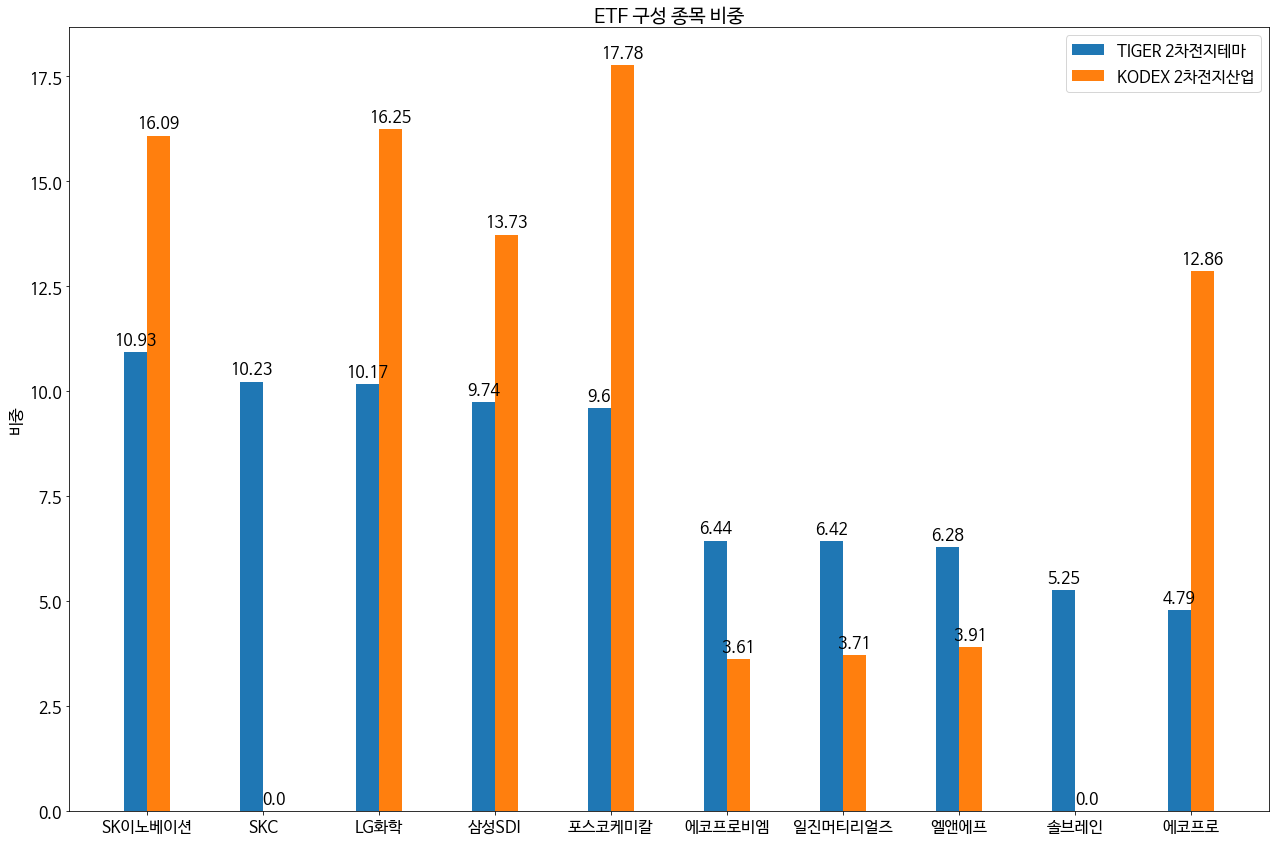

In [9]:
df2['TIGER 2차전지테마'] = df2['TIGER 2차전지테마'].apply(lambda x: float('{:.2f}'.format(x)))
df2['KODEX 2차전지산업'] = df2['KODEX 2차전지산업'].apply(lambda x: float('{:.2f}'.format(x)))

import numpy as np


plt.rc('font', family='NanumBarunGothic', size =16) 

fig, ax = plt.subplots(figsize = (18,12))
x = np.arange(len(df2.index))
width = 0.20

rects1 = ax.bar(x-(width/2), df2['TIGER 2차전지테마'], width, label = 'TIGER 2차전지테마')
rects2 = ax.bar(x+(width/2), df2['KODEX 2차전지산업'], width, label = 'KODEX 2차전지산업')

ax.set_ylabel('비중')
ax.set_title('ETF 구성 종목 비중')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(df2.index)

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,3), textcoords = 'offset points', ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Case 1. 과거 종가만 사용

###데이터 준비

In [10]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization
import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)
Kodex.drop(['니켈','코발트','macd','괴리율','등락률','sk이노베이션','포스코케미칼','LG화학','updown','bb_bbm','bb_bbh','bb_bbl','MA_15','MA_7','Score','NAV','시가','고가','거래량','저가'],axis=1,inplace=True)
Kodex

,종가
날짜,
2018-10-18,9475
2018-10-19,9545
2018-10-22,9815
2018-10-23,9385
2018-10-24,9200
...,...
2021-04-26,19720
2021-04-27,19795
2021-04-28,19500


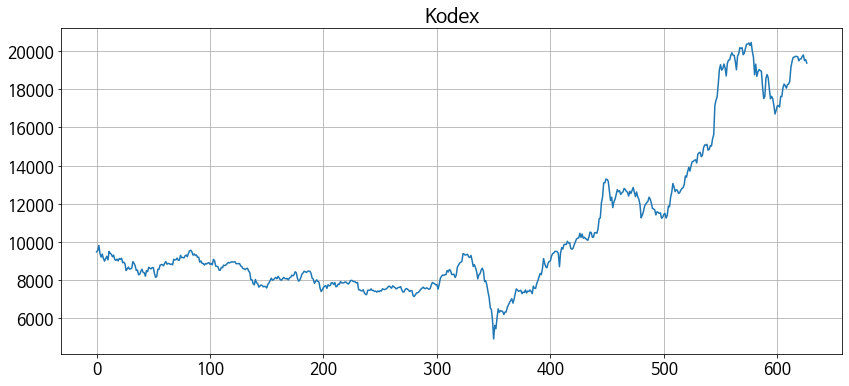

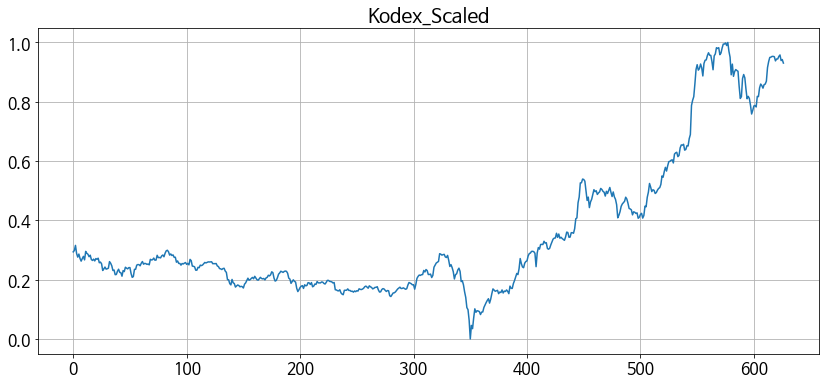

In [33]:
Kodex = np.array(Kodex).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [34]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(622, 5) (622,)


In [35]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

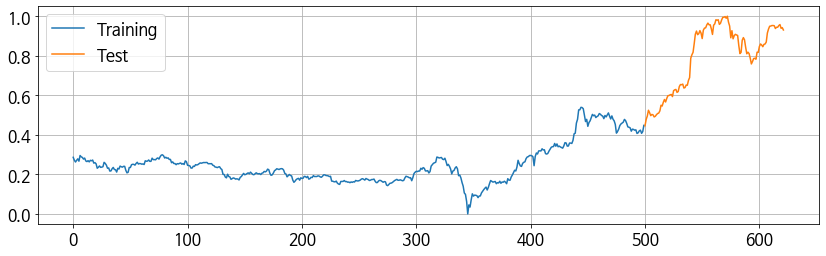

In [36]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [37]:
X_train = X_train.reshape(-1,5,1)
X_test = X_test.reshape(-1,5,1)

###LSTM

In [39]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s 13ms/step - loss: 0.2146
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0843
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0788
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0698
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0560
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0477
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0495
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0449
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0416
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0398
Epoch 11/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0406
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0390
Epoch 13/100
16/16 [=====

###결과

#### lstm(LSTM)의 파라미터가 4352인 이유는 우선, 입력변수(1개)에서 LSTM 은닉 뉴런(노드)에 연결되는 가중치(32개)가 **32개**이고, 은닉상태에서 곱해지는 가중치가 32 곱하기 32개 = **1024개**, 그리고 마지막으로 **32개**의 절편이 존재하며 이를 합하면, 1088 개가 되고 이것은 RNN의 파라미터 수이고, LSTM의 경우에는 **4배의 파라미터가 발생**되어, 1088*4개 = 4352개의 파라미터가 존재함.

####4352 = 4x(32x32+32+32)

####8320 = 4x(32x32+32x32+32)

In [40]:
regressor.summary()
y_pred = regressor.predict(X_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 32)             4352      
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)               

* return_sequences : 시퀀스 출력 여부

LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력을 할 수 있습니다.

 many to many 문제를 풀거나 LSTM 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 옵션을 사용합니다. 자세한 것은 뒤에서 살펴보겠습니다.
  아래 그림에서 왼쪽은 return_sequences=False일 때, 오른쪽은 return_sequence=True일 때의 형상입니다.


  <img src="http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_LSTM2.png" width="1200" height="300">

Text(0, 0.5, 'Price')

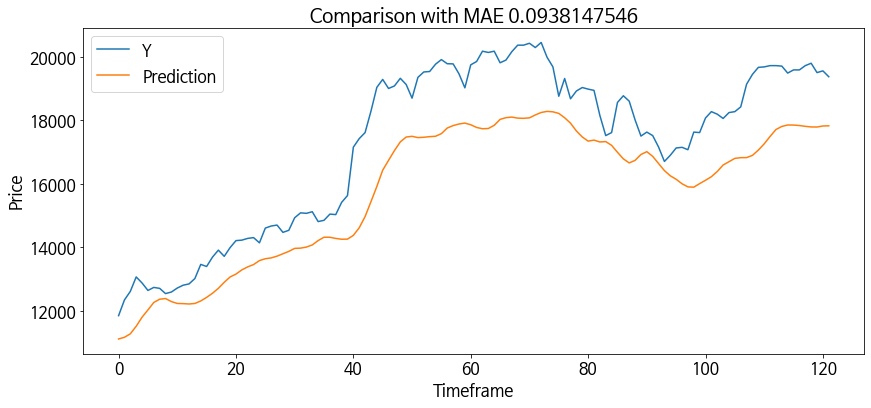

In [41]:
plt.figure(figsize=(14,6))
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [42]:
err_model1 = regressor.evaluate(X_test, y_test, batch_size=32)
models = pd.DataFrame({
    'Model': ['LSTM with Close'],
    'Score': [err_model1]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 5ms/step - loss: 0.0938


,Model,Score
0,LSTM with Close,0.093815


## Case 2. 기술적 지표

###데이터 준비

In [23]:
#def get_macd(df, short=12, long=26, t=9):
#  df = pd.DataFrame(df)
#  ma_12 = df['종가'].ewm(span=12).mean()
#  ma_26 = df['종가'].ewm(span=26).mean()
#  macd = ma_12 - ma_26
#  macds = macd.ewm(span=9).mean()
#  macdo = macd - macds
#  df = df.assign(macd=macd, macds=macds, macdo=macdo).dropna()
#  return df

In [ ]:
#!pip install ta

In [43]:
#from ta.utils import dropna
#from ta.volatility import BollingerBands
#Kodex
#Kodex = stock.get_etf_ohlcv_by_date("20180912","20210430",'305720')
#Kodex = get_macd(Kodex)

# Clean NaN values
#Kodex = dropna(Kodex)

# Initialize Bollinger Bands Indicator
#indicator_bb = BollingerBands(close=Kodex["종가"], window=20, window_dev=2)

# Add Bollinger Bands features
#Kodex['bb_bbm'] = indicator_bb.bollinger_mavg()
#Kodex['bb_bbh'] = indicator_bb.bollinger_hband()
#Kodex['bb_bbl'] = indicator_bb.bollinger_lband()

#Kodex = Kodex.dropna(axis=0)

Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)

Kodex.drop(['NAV','시가','고가','저가','거래량','니켈','코발트','Score','등락률','sk이노베이션','포스코케미칼','LG화학','updown'],axis=1,inplace=True)
Kodex

,종가,macd,bb_bbm,bb_bbh,bb_bbl,괴리율,MA_15,MA_7
날짜,,,,,,,,
2018-10-18,9475,-107.708406,9766.00,10509.226749,9022.773251,-0.46,9670.000000,9370.000000
2018-10-19,9545,-97.813377,9746.50,10491.430198,9001.569802,-0.45,9633.000000,9395.714286
2018-10-22,9815,-70.411951,9737.75,10475.106596,9000.393404,0.51,9602.666667,9518.571429
2018-10-23,9385,-78.163100,9698.50,10423.104030,8973.895970,-0.30,9547.000000,9522.142857
2018-10-24,9200,-96.271023,9650.75,10374.595805,8926.904195,0.16,9482.000000,9491.428571
...,...,...,...,...,...,...,...,...
2021-04-26,19720,420.010008,18909.75,20468.366293,17351.133707,-0.16,19228.666667,19645.714286
2021-04-27,19795,423.439269,19018.25,20504.457506,17532.042494,-0.45,19344.666667,19656.428571
2021-04-28,19500,397.767731,19112.75,20462.888789,17762.611211,0.03,19428.666667,19625.000000


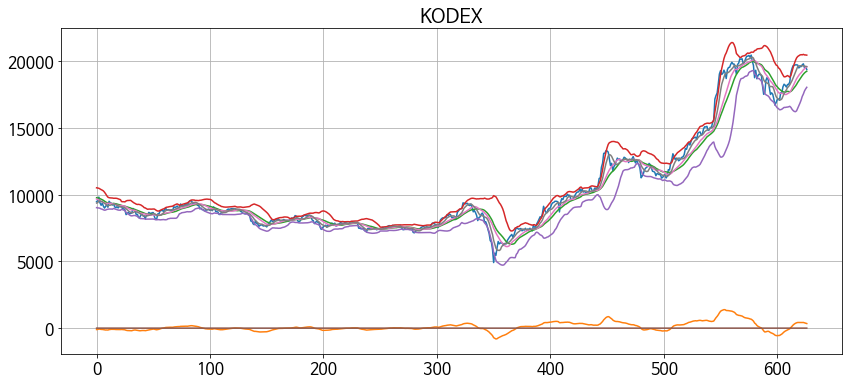

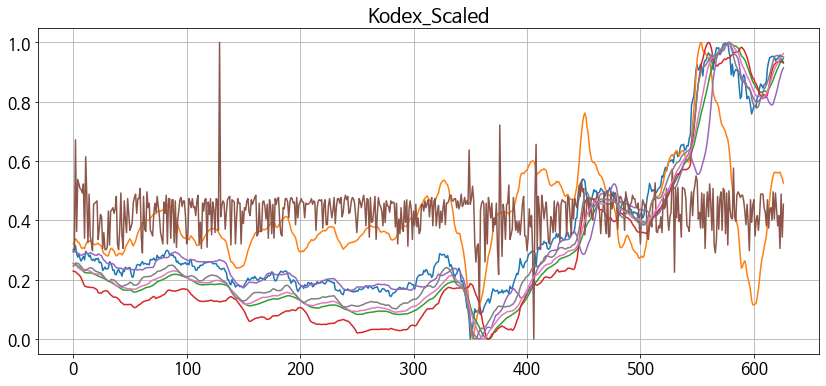

In [44]:
Kodex = np.array(Kodex).reshape(-1,8)
plt.figure(figsize=(14,6))
plt.title("KODEX")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [45]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:8])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(622, 5, 8) (622,)


In [46]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

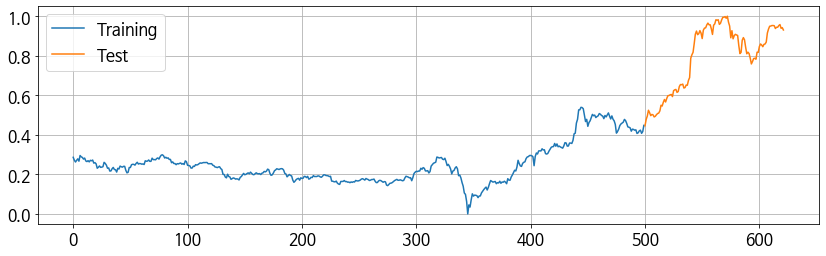

In [47]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [48]:
X_train = X_train.reshape(-1,5,8)
X_test = X_test.reshape(-1,5,8)

###LSTM

In [49]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],8)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 8s 12ms/step - loss: 0.1991
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0796
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0763
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0551
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0458
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0448
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0453
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0435
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0406
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0392
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0395
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0380
Epoch 13/100
16/16 [=====

###결과

In [50]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 32)             5248      
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

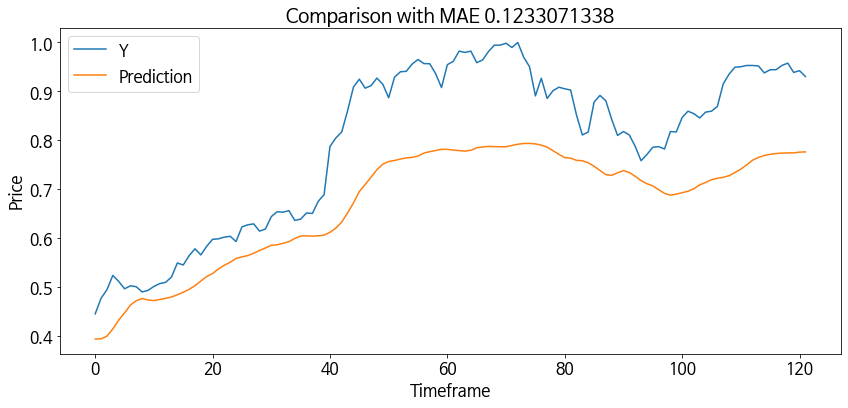

In [51]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [52]:
err_model2 = regressor.evaluate(X_test, y_test, batch_size=32)
models = pd.DataFrame({
    'Model': ['LSTM with only Close', 'LSTM with Technical Analysis'],
    'Score': [err_model1,err_model2]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 5ms/step - loss: 0.1233


,Model,Score
0,LSTM with only Close,0.093815
1,LSTM with Technical Analysis,0.123307


##Case 3. 2차전지산업관련 뉴스 감성 점수

###크롤링

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 5.3MB/s 


In [ ]:
#dates = [date.strftime("%Y.%m.%d") for date in Tiger.index]

In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re

title_text=[]
contents_text=[]
dates_text = []
#result=[]

#엑셀로 저장하기 위한 변수
RESULT_PATH ='/content/drive'  #결과 저장할 경로

#날짜 범위 리스트로 만들기
def date_range(start, end):
    start = datetime.strptime(start, "%Y.%m.%d")
    end = datetime.strptime(end, "%Y.%m.%d")
    dates = [date.strftime("%Y.%m.%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

#def contents_cleansing(contents):
#    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
#    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
#    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
#    contents_text.append(third_cleansing_contents)
#    #print(contents_text)

#크롤링 시작
def crawler(query,s_date,e_date):
  dates= [date.strftime("%Y.%m.%d") for date in Tiger.index]
  page_num = [1,11,21,31,41]
  #maxpage_t =41
  for x in dates:
    #print(x)
    for page_number in page_num:
      ds = x.replace(".","")
      de = ds
      url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort=0"+"&ds=" + x + "&de=" + x + "&nso=so%3Ar%2Cp%3Afrom" + ds + "to" + de + "%2Ca%3A&start=" + str(page_number)
      #url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort={1}&photo=0&field=0&reporter_article=&pd=3&ds={2}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(query,sort,x,str(page_num))
      #print(url)
      response = requests.get(url)
      html = response.text

      #뷰티풀소프의 인자값 지정
      soup = BeautifulSoup(html, 'html.parser')

      #뉴스 날짜
#      bbs = soup.find_all('span', 'info')
#      for bb in bbs:
#        t = bb.text
#        dates_text.append(t)
#      search = "면"
#      for word in dates_text:
#        if search in word: 
#          dates_text.remove(word)


      #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
      atags = soup.find_all('a', 'news_tit')
      for atag in atags:
        title = atag.get('title')
        title_text.append(title)     #제목
        dates_text.append(x)
            
      #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
      #contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
      #for contents_list in contents_lists:
      #  contents_cleansing(contents_list) #본문요약 정제화


      #모든 리스트 딕셔너리형태로 저장
      #result= {"Date":dates_text,"title":title_text}
      df1 = pd.DataFrame(dates_text)
      df2 = pd.DataFrame(title_text) #df로 변환
      result = pd.concat([df1,df2],axis=1)
      #print(result)

  outputFileName = '{0}~{1} {2} 관련 뉴스.xlsx'.format(s_date.replace(".",""), e_date.replace(".",""), query)
  writer = pd.ExcelWriter(outputFileName, engine='xlsxwriter')
  result.to_excel(writer, sheet_name= '{0}~{1} {2} 뉴스'.format(s_date.replace(".",""), e_date.replace(".",""), query))
  writer.save()

#메인함수
def main():
    info_main = input("="*50+"\n"+"입력 형식에 맞게 입력해주세요."+"\n"+" 시작하시려면 Enter를 눌러주세요."+"\n"+"="*50)
    query = input("검색어 입력: ") #네이버, 부동산...
    s_date = input("시작날짜 입력(예시:2019.01.01):")
    e_date = input("끝날짜 입력:")
    crawler(query,s_date, e_date)

In [ ]:
main()

입력 형식에 맞게 입력해주세요.
 시작하시려면 Enter를 눌러주세요.
검색어 입력: 2차전지산업


KeyboardInterrupt: ignored

###감성 점수 계산

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 4.9MB/s 
     |████████████████████████████████| 460kB 37.3MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!git clone https://github.com/FinanceData/corpus.git

Cloning into 'corpus'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.


In [ ]:
from konlpy.tag import Kkma

engine = Kkma()
polarity_dic = pd.read_csv('corpus/kosac/polarity.csv')
polarity_dic.set_index('ngram', inplace=True)

def polarity_score(text):
    pos_tags = engine.pos(text)

    # n-gram
    unigram = ['/'.join(p) for p in pos_tags]
    bigram = [';'.join(z) for z in zip(unigram, unigram[1:])]
    trigram = [';'.join(z) for z in zip(*[unigram[i:] for i in range(3)])]
    
    p_score = 0
    # polarity score = (p-n) / (p+n)
    for ngram in [unigram, bigram, trigram]:
        cond = polarity_dic.index.isin(ngram)
        s = polarity_dic.loc[cond, :].sum()
        if s['POS'] + s['NEG'] > 0: # div 0 방지
            p_score += (s['POS'] - s['NEG']) / (s['POS'] + s['NEG'])
    return p_score

In [ ]:
news = pd.read_excel('/content/20181018~20210430 2차전지산업 관련 뉴스.xlsx')

In [ ]:
news.columns = ['Count', 'Date', 'Title']
news.head()

In [ ]:
news.loc[:,'Title']

0                          대보마그네틱 내달 코스닥 입성…"2차전지 수요로 고성장"
1                    삼성SDI LG화학 SK이노베이션, 중국 전기차배터리 구조조정 수혜
2                                        극우 현상? 한국도 다르지 않다
3                        '글로벌 EMF 1위' 대보마그네틱, 내달 코스닥 상장 앞둬
4                                 창원상의, 2018 창원지역상장사 IR 개최
                               ...                        
21400     [공석환의 주식시황] “공매도 걱정? 최근 10거래일 연기금 매수 많은 종목 따르는게"
21401    국민의힘 새 사령탑 김기현 신임 원내대표는 누구? | 한때 대선 잠룡.... 울산시...
21402                      SNE리서치, 전기차용 차세대 배터리 온라인 세미나 연다
21403               [전문가 칼럼] 스마트공장을 위한 현장의 로봇 적용 엔지니어링(3편)
21404                   LG상사, 1분기 영업익 1133억원 기록 '분기 사상 최대'
Name: Title, Length: 21405, dtype: object

In [ ]:
news_scores = []
for i in news.loc[:,'Title']:
  news_score = polarity_score(i)
  #print(news_score)
  news_scores.append(news_score)

In [ ]:
news_scores_df = pd.DataFrame(data = news_scores, columns=['Score'])

In [ ]:
result = pd.concat([news,news_scores_df],axis=1)
result.head()

,Count,Date,Title,Score
0,0,2018.10.18,"대보마그네틱 내달 코스닥 입성…""2차전지 수요로 고성장""",1.000000
1,1,2018.10.18,"삼성SDI LG화학 SK이노베이션, 중국 전기차배터리 구조조정 수혜",-0.538824
2,2,2018.10.18,극우 현상? 한국도 다르지 않다,-0.094488
3,3,2018.10.18,"'글로벌 EMF 1위' 대보마그네틱, 내달 코스닥 상장 앞둬",0.000000
4,4,2018.10.18,"창원상의, 2018 창원지역상장사 IR 개최",1.000000


In [ ]:
dr = [date.strftime("%Y.%m.%d") for date in Tiger.index]
mean_text = []
for i in dr:
  Smean = result.loc[result['Date']==i,'Score'].mean()
  mean_text.append(Smean)

df1= pd.DataFrame(dr)
df2= pd.DataFrame(mean_text)

date_mean_score = pd.concat([df1,df2],axis=1)

In [ ]:
date_mean_score.columns = ['Date','Score']
type(date_mean_score)

pandas.core.frame.DataFrame

In [ ]:
date_mean_score.to_excel('2차전지산업 관련 뉴스 감성점수.xlsx')

In [ ]:
date_mean_score = date_mean_score.drop('Date', axis=1)

In [ ]:
date_mean_score

,Score
0,0.304989
1,0.139543
2,0.004679
3,0.140723
4,0.397520
...,...
622,0.158912
623,0.192055
624,0.426701
625,0.282957


###데이터 준비

In [53]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)

Kodex.drop(['NAV','시가','고가','저가','거래량','니켈','코발트','macd','괴리율','등락률','sk이노베이션','포스코케미칼','LG화학','updown','bb_bbm','bb_bbh','bb_bbl','MA_15','MA_7'],axis=1,inplace=True)
Kodex

,종가,Score
날짜,,
2018-10-18,9475,0.304989
2018-10-19,9545,0.139543
2018-10-22,9815,0.004679
2018-10-23,9385,0.140723
2018-10-24,9200,0.397520
...,...,...
2021-04-26,19720,0.158912
2021-04-27,19795,0.192055
2021-04-28,19500,0.426701


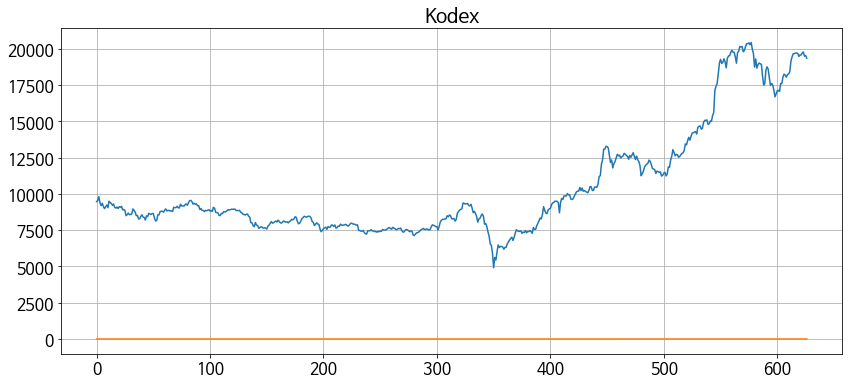

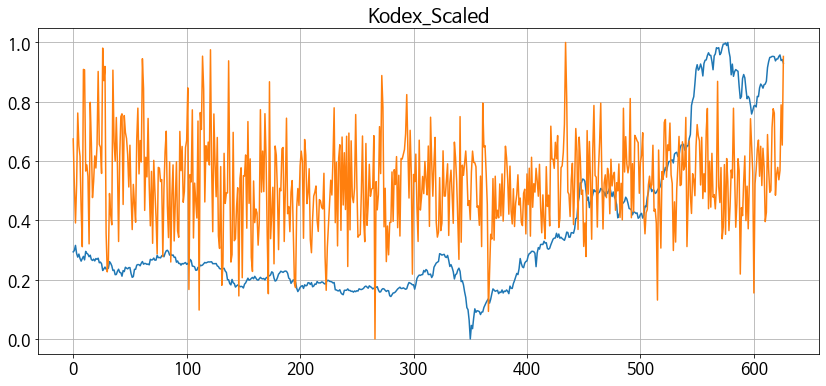

In [54]:
Kodex = np.array(Kodex).reshape(-1,2)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [55]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:2])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y) # array()함수의 인자로 리스트를 넣어 Numpy 배열을 생성시킴
print(X.shape, y.shape)

(622, 5, 2) (622,)


In [56]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]    

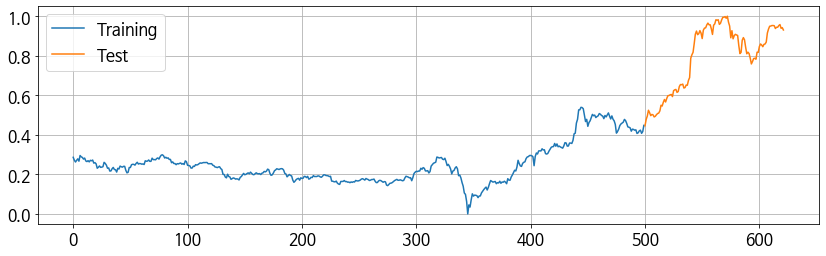

In [57]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [58]:
X_train = X_train.reshape(-1,5,2)
X_test = X_test.reshape(-1,5,2)

###LSTM

In [59]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],2)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 8s 12ms/step - loss: 0.2178
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0890
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0827
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0743
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0766
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0685
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0572
Epoch 8/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0494
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0401
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0397
Epoch 11/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0450
Epoch 12/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0403
Epoch 13/100
16/16 [=====

###결과

In [60]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 5, 32)             4480      
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

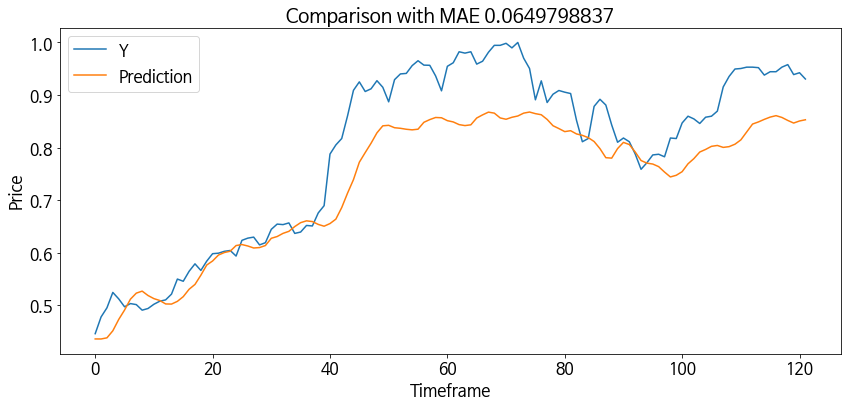

In [61]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [62]:
err_model3 = regressor.evaluate(X_test, y_test, batch_size=30)

models = pd.DataFrame({
    'Model': ['LSTM with Close', 'LSTM with Technical Analysis','LSTM with Sentimental Score'],
    'Score': [err_model1,err_model2,err_model3]})
models.sort_values(by='Score', ascending=True)

5/5 [==============================] - 2s 5ms/step - loss: 0.0650


,Model,Score
2,LSTM with Sentimental Score,0.064980
0,LSTM with Close,0.093815
1,LSTM with Technical Analysis,0.123307


## Case 4.nohlcv 사용

### 데이터 준비

In [63]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)

Kodex.drop(['니켈','코발트','macd','괴리율','등락률','sk이노베이션','포스코케미칼','LG화학','updown','bb_bbm','bb_bbh','bb_bbl','MA_15','MA_7','Score'],axis=1,inplace=True)
Kodex

,종가,NAV,시가,고가,저가,거래량
날짜,,,,,,
2018-10-18,9475,9519.25,9630,9635,9450,528826
2018-10-19,9545,9588.55,9420,9600,9305,466642
2018-10-22,9815,9765.65,9555,9815,9460,616878
2018-10-23,9385,9413.22,9755,9775,9340,644986
2018-10-24,9200,9185.32,9520,9540,9070,567089
...,...,...,...,...,...,...
2021-04-26,19720,19751.68,19655,19750,19420,982974
2021-04-27,19795,19884.90,19760,19895,19700,1530711
2021-04-28,19500,19493.82,19695,19730,19370,1013162


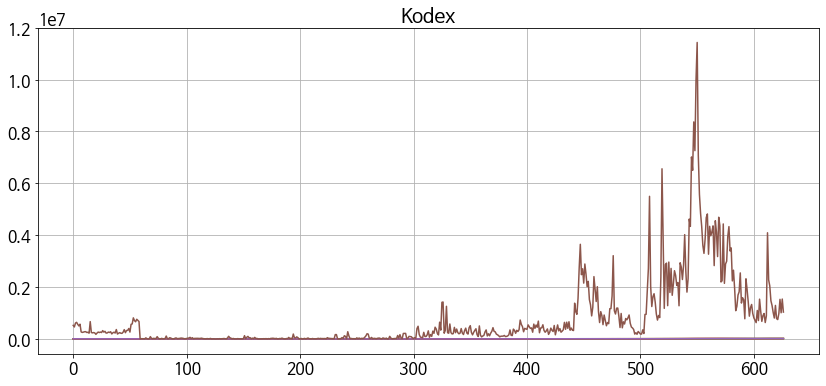

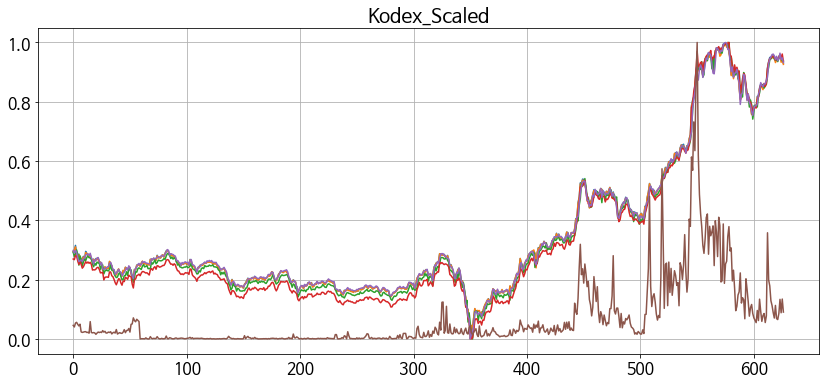

In [64]:
Kodex = np.array(Kodex).reshape(-1,6)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [65]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:6])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(622, 5, 6) (622,)


In [66]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]   

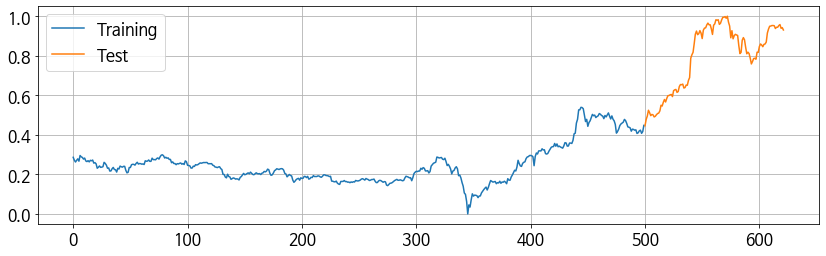

In [67]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [68]:
X_train = X_train.reshape(-1,5,6)
X_test = X_test.reshape(-1,5,6)

### LSTM

In [69]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],6)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s 13ms/step - loss: 0.2112
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0835
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0709
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0617
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0460
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0476
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0444
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0434
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0422
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0392
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0359
Epoch 12/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0368
Epoch 13/100
16/16 [=====

###결과

In [70]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 5, 32)             4992      
_________________________________________________________________
dropout_24 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_26 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

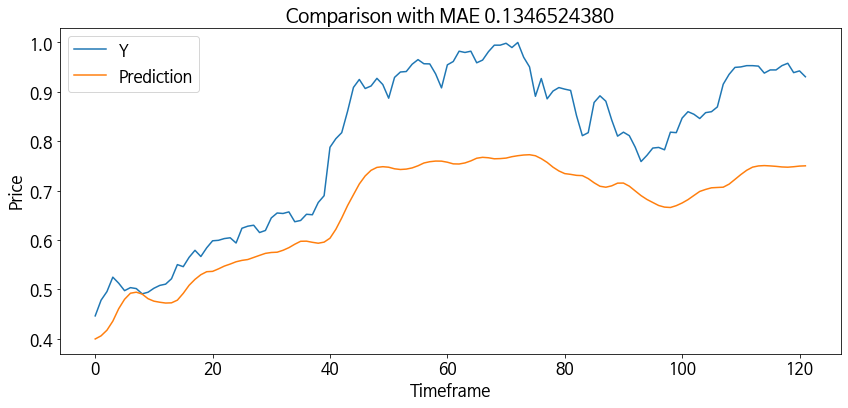

In [71]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [72]:
err_model4 = regressor.evaluate(X_test, y_test, batch_size=32)

models = pd.DataFrame({
    'Model': ['Only Close', 'with Technical Analysis','with Sentimental Score' ,'with nohlcv'],
    'Score': [err_model1,err_model2,err_model3,err_model4]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 5ms/step - loss: 0.1347


,Model,Score
2,with Sentimental Score,0.064980
0,Only Close,0.093815
1,with Technical Analysis,0.123307
3,with nohlcv,0.134652


## Case 5. 거시데이터 사용(원자재 가격 데이터)

### 데이터 준비

In [73]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)
Kodex.drop(['macd','괴리율','등락률','sk이노베이션','포스코케미칼','LG화학','updown','bb_bbm','bb_bbh','bb_bbl','MA_15','MA_7','Score','NAV','시가','고가','거래량','저가'],axis=1,inplace=True)
Kodex

,종가,니켈,코발트
날짜,,,
2018-10-18,9475,12140,58000
2018-10-19,9545,12470,60750
2018-10-22,9815,12455,60750
2018-10-23,9385,12330,60750
2018-10-24,9200,12295,60750
...,...,...,...
2021-04-26,19720,16449,46500
2021-04-27,19795,16914,46495
2021-04-28,19500,17223,46490


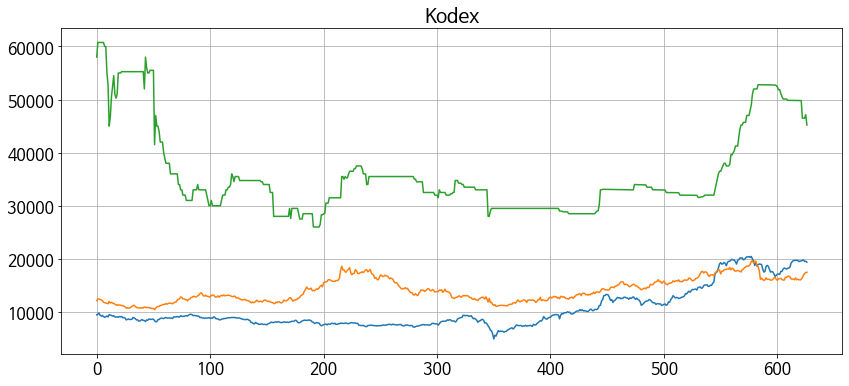

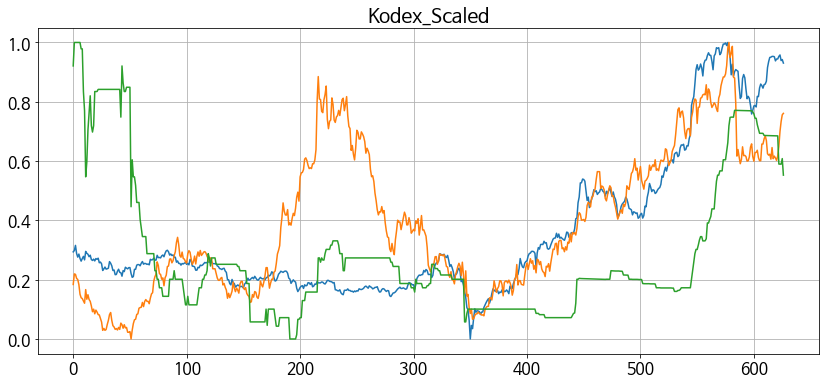

In [74]:
Kodex = np.array(Kodex).reshape(-1,3)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [75]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:3])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(622, 5, 3) (622,)


In [76]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]   

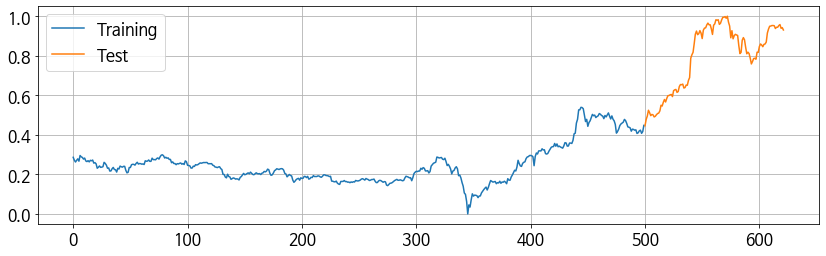

In [77]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [78]:
X_train = X_train.reshape(-1,5,3)
X_test = X_test.reshape(-1,5,3)

###LSTM

In [79]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],3)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s 12ms/step - loss: 0.2030
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0928
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0846
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0811
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0748
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0657
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0600
Epoch 8/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0475
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0479
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0412
Epoch 11/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0372
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0379
Epoch 13/100
16/16 [=====

###결과

In [80]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 5, 32)             4608      
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_30 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

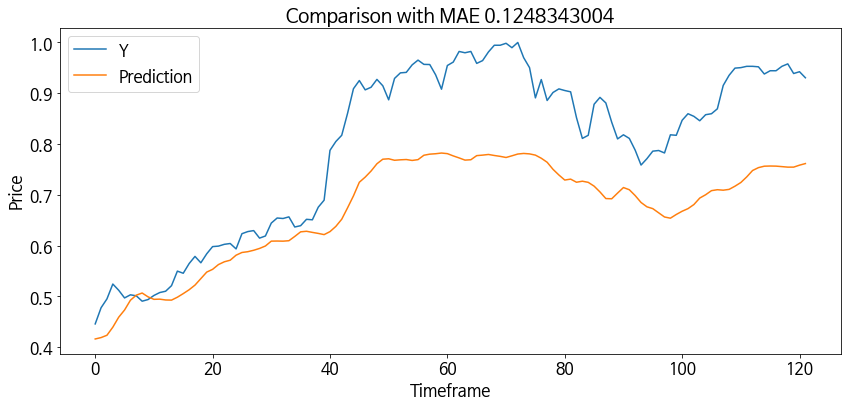

In [81]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [82]:
err_model5 = regressor.evaluate(X_test, y_test, batch_size=32)

models = pd.DataFrame({
    'Model': ['Only Close', 'with Technical Analysis','with Sentimental Score' ,'with nohlcv', 'with materials'],
    'Score': [err_model1,err_model2,err_model3,err_model4,err_model5]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 5ms/step - loss: 0.1248


,Model,Score
2,with Sentimental Score,0.064980
0,Only Close,0.093815
1,with Technical Analysis,0.123307
4,with materials,0.124834
3,with nohlcv,0.134652


## Case 6. 구성품목 Top3 사용

### 데이터 준비

In [83]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)
Kodex.drop(['니켈','코발트','macd','괴리율','등락률','updown','bb_bbm','bb_bbh','bb_bbl','MA_15','MA_7','Score','NAV','시가','고가','거래량','저가'],axis=1,inplace=True)
Kodex

,종가,sk이노베이션,포스코케미칼,LG화학
날짜,,,,
2018-10-18,9475,220000,65609,317000
2018-10-19,9545,212500,67110,330000
2018-10-22,9815,214000,69645,337500
2018-10-23,9385,207000,63731,329000
2018-10-24,9200,207000,61385,330500
...,...,...,...,...
2021-04-26,19720,273500,165500,883000
2021-04-27,19795,280500,159500,891000
2021-04-28,19500,270000,155500,890000


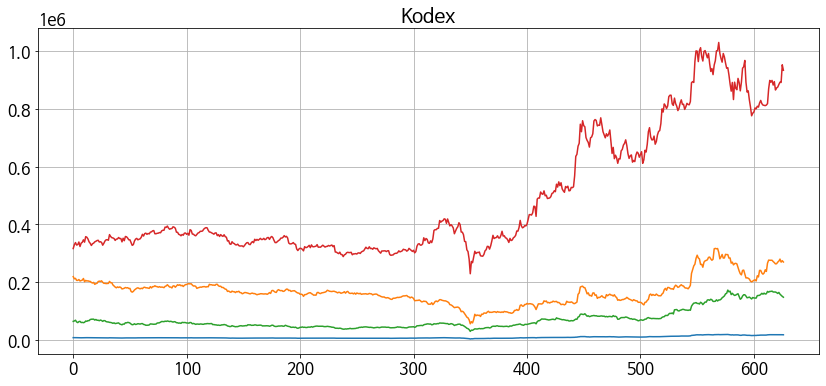

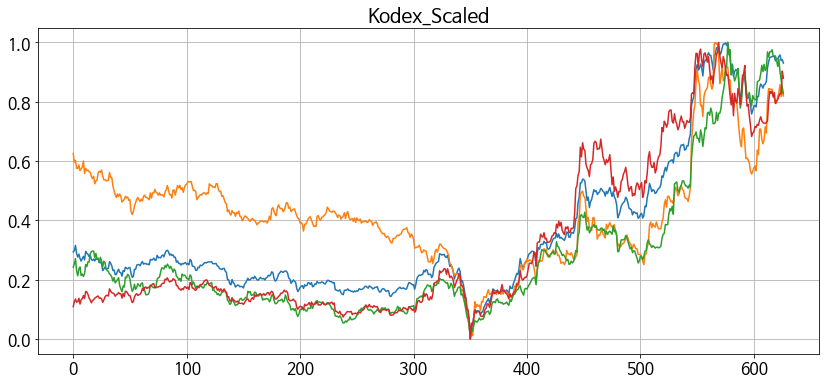

In [84]:
Kodex = np.array(Kodex).reshape(-1,4)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [85]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:4])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(622, 5, 4) (622,)


In [86]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]   

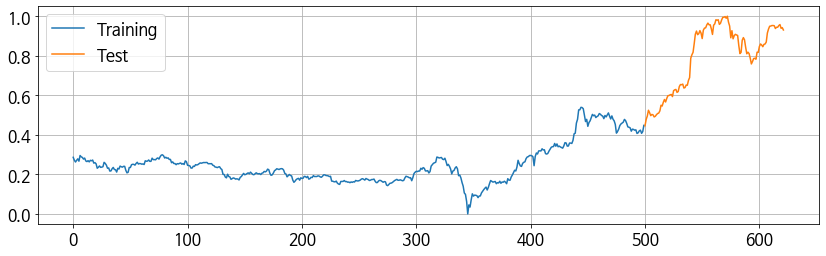

In [87]:
plt.figure(figsize=(14,4))
plt.plot(range(500),y_train)
plt.plot(range(500, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [88]:
X_train = X_train.reshape(-1,5,4)
X_test = X_test.reshape(-1,5,4)

###LSTM

In [89]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s 12ms/step - loss: 0.2080
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0841
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0755
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0640
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0519
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0496
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0463
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0419
Epoch 9/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0425
Epoch 10/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0410
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0413
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0366
Epoch 13/100
16/16 [=====

###결과

In [90]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 5, 32)             4736      
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

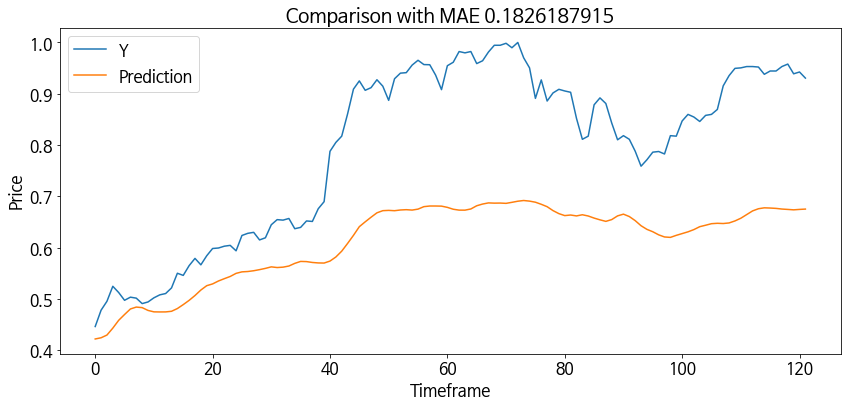

In [91]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [92]:
err_model6 = regressor.evaluate(X_test, y_test, batch_size=32)

models = pd.DataFrame({
    'Model': ['Only Close', 'with Technical Analysis','with Sentimental Score' ,'with nohlcv', 'with materials','with Compononet Top3'],
    'Score': [err_model1,err_model2,err_model3,err_model4,err_model5, err_model6]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 5ms/step - loss: 0.1826


,Model,Score
2,with Sentimental Score,0.064980
0,Only Close,0.093815
1,with Technical Analysis,0.123307
4,with materials,0.124834
3,with nohlcv,0.134652
5,with Compononet Top3,0.182619


## Case 7.모두 사용

###데이터 준비

In [93]:
Kodex = pd.read_excel('/content/kodex.xlsx', index_col=0)
Kodex.drop(['updown','등락률'],axis=1,inplace=True)
Kodex

,종가,NAV,시가,고가,저가,거래량,macd,bb_bbm,bb_bbh,bb_bbl,니켈,코발트,Score,괴리율,sk이노베이션,포스코케미칼,LG화학,MA_15,MA_7
날짜,,,,,,,,,,,,,,,,,,,
2018-10-18,9475,9519.25,9630,9635,9450,528826,-107.708406,9766.00,10509.226749,9022.773251,12140,58000,0.304989,-0.46,220000,65609,317000,9670.000000,9370.000000
2018-10-19,9545,9588.55,9420,9600,9305,466642,-97.813377,9746.50,10491.430198,9001.569802,12470,60750,0.139543,-0.45,212500,67110,330000,9633.000000,9395.714286
2018-10-22,9815,9765.65,9555,9815,9460,616878,-70.411951,9737.75,10475.106596,9000.393404,12455,60750,0.004679,0.51,214000,69645,337500,9602.666667,9518.571429
2018-10-23,9385,9413.22,9755,9775,9340,644986,-78.163100,9698.50,10423.104030,8973.895970,12330,60750,0.140723,-0.30,207000,63731,329000,9547.000000,9522.142857
2018-10-24,9200,9185.32,9520,9540,9070,567089,-96.271023,9650.75,10374.595805,8926.904195,12295,60750,0.397520,0.16,207000,61385,330500,9482.000000,9491.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,19720,19751.68,19655,19750,19420,982974,420.010008,18909.75,20468.366293,17351.133707,16449,46500,0.158912,-0.16,273500,165500,883000,19228.666667,19645.714286
2021-04-27,19795,19884.90,19760,19895,19700,1530711,423.439269,19018.25,20504.457506,17532.042494,16914,46495,0.192055,-0.45,280500,159500,891000,19344.666667,19656.428571
2021-04-28,19500,19493.82,19695,19730,19370,1013162,397.767731,19112.75,20462.888789,17762.611211,17223,46490,0.426701,0.03,270000,155500,890000,19428.666667,19625.000000


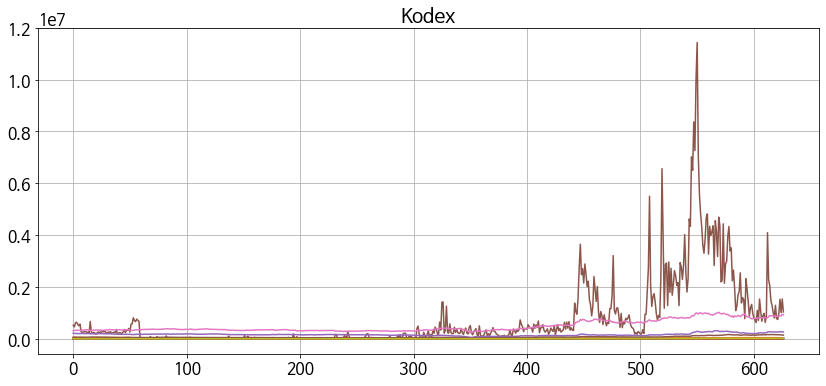

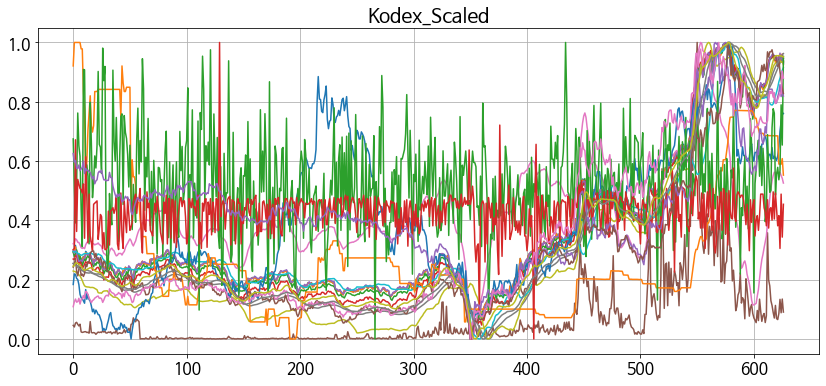

In [94]:
Kodex = np.array(Kodex).reshape(-1,19)
plt.figure(figsize=(14,6))
plt.title("Kodex")
plt.grid()
plt.plot(Kodex)

sc = MinMaxScaler()
KodexSC = sc.fit_transform(Kodex)
plt.figure(figsize=(14,6))
plt.title("Kodex_Scaled")
plt.grid()
plt.plot(KodexSC)

In [95]:
X = []
y = []
for i in range(5, len(KodexSC)):
    X.append(KodexSC[i-5:i, 0:19])
    y.append(KodexSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(622, 5, 19) (622,)


In [96]:
X_train = X[:500,:]
X_test = X[500:,:]

y_train = y[:500]
y_test = y[500:]   

In [97]:
X_train = X_train.reshape(-1,5,19)
X_test = X_test.reshape(-1,5,19)

###LSTM

In [98]:
regressor = Sequential()

regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],19)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 7s 14ms/step - loss: 0.1945
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0783
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0684
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0623
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0521
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0466
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0423
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0466
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0391
Epoch 10/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0399
Epoch 11/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0408
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0379
Epoch 13/100
16/16 [=====

###결과

In [99]:
y_pred = regressor.predict(X_test)
regressor.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 5, 32)             6656      
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 32)               

Text(0, 0.5, 'Price')

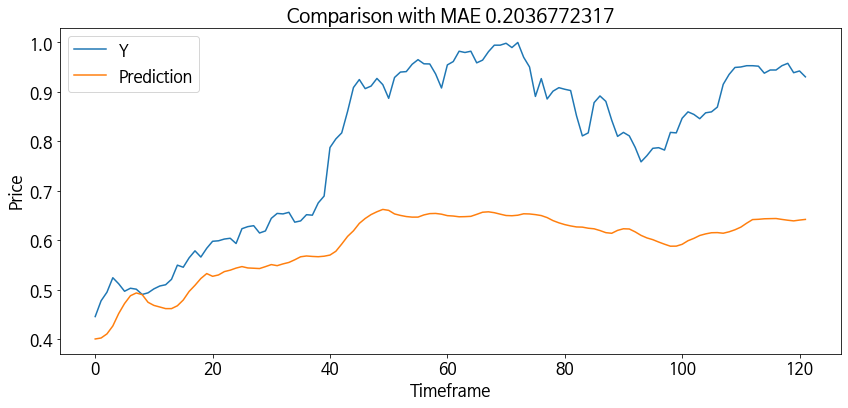

In [100]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(mean_absolute_error(y_test, y_pred)))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [101]:
err_model7 = regressor.evaluate(X_test, y_test, batch_size=32)

models = pd.DataFrame({
    'Model': ['Only Close', 'with Technical Analysis','with Sentimental Score' ,'with nohlcv', 'with materials','with Compononet Top3','All'],
    'Score': [err_model1,err_model2,err_model3,err_model4,err_model5, err_model6,err_model7]})
models.sort_values(by='Score', ascending=True)

4/4 [==============================] - 2s 6ms/step - loss: 0.2037


,Model,Score
2,with Sentimental Score,0.064980
0,Only Close,0.093815
1,with Technical Analysis,0.123307
4,with materials,0.124834
3,with nohlcv,0.134652
5,with Compononet Top3,0.182619
6,All,0.203677
